Họ và tên: Trần Hoàng Hà My
MSSV: 22520903

### LAB 5

### Assignment 1 (2 scores):
- Use Numpy only to implement the Gaussian Mixture Model.
- Train Gaussian Mixture Model with EM method.

In [176]:
import numpy as np
import matplotlib.pyplot as plt

In [177]:
# === 1. Tạo dữ liệu toy dataset ===
def generate_data():
    np.random.seed(42)
    cov = np.array([[1, 0], [0, 1]])
    X1 = np.random.multivariate_normal([2, 2], cov, 200)
    X2 = np.random.multivariate_normal([8, 3], cov, 200)
    X3 = np.random.multivariate_normal([3, 6], cov, 200)
    X = np.vstack([X1, X2, X3])
    return X

In [ ]:
class GMM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4, reg_covar=1e-6, verbose=False):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.reg_covar = reg_covar
        self.verbose = verbose

        self.weights = None       # = pi
        self.means = None         # = mu
        self.covariances = None   # = sigma
        self.log_likelihood_history = []

    def _multivariate_gaussian(self, X, mean, cov):
        d = X.shape[1]
        reg_cov = cov + self.reg_covar * np.eye(d)
        try:
            L = np.linalg.cholesky(reg_cov)
        except np.linalg.LinAlgError:
            reg_cov += 10 * self.reg_covar * np.eye(d)
            L = np.linalg.cholesky(reg_cov)

        det_cov = np.prod(np.diag(L)) ** 2
        norm_const = 1.0 / np.sqrt((2 * np.pi) ** d * det_cov)

        diff = X - mean
        z = np.linalg.solve(L, diff.T).T
        return norm_const * np.exp(-0.5 * np.sum(z ** 2, axis=1))

    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        rng = np.random.default_rng()

        self.weights = np.full(self.n_components, 1 / self.n_components)
        indices = rng.choice(n_samples, self.n_components, replace=False)
        self.means = X[indices]
        self.covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])

    def _e_step(self, X):
        n_samples = X.shape[0]
        probs = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            probs[:, k] = self.weights[k] * self._multivariate_gaussian(X, self.means[k], self.covariances[k])
        total = np.sum(probs, axis=1, keepdims=True)
        return probs / (total + 1e-12), total

    def _m_step(self, X, responsibilities):
        N_k = np.sum(responsibilities, axis=0)
        self.weights = N_k / X.shape[0]
        self.means = (responsibilities.T @ X) / (N_k[:, np.newaxis] + 1e-12)

        for k in range(self.n_components):
            diff = X - self.means[k]
            weighted = responsibilities[:, k][:, np.newaxis] * diff
            self.covariances[k] = (weighted.T @ diff) / (N_k[k] + 1e-12) + self.reg_covar * np.eye(X.shape[1])

    def fit(self, X):
        self._initialize_parameters(X)
        prev_ll = -np.inf

        if self.verbose:
            print("Training GMM...")

        for i in range(self.max_iter):
            responsibilities, total_prob = self._e_step(X)
            self._m_step(X, responsibilities)

            ll = np.sum(np.log(total_prob + 1e-12))
            self.log_likelihood_history.append(ll)

            if self.verbose:
                print(f"Step {i + 1}: log-likelihood = {ll:.4f}")

            if abs(ll - prev_ll) < self.tol:
                if self.verbose:
                    print("Converged.")
                break
            prev_ll = ll

    def predict_proba(self, X):
        probs, _ = self._e_step(X)
        return probs

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

Training GMM...
Step 1: log-likelihood = -4497.6097
Step 2: log-likelihood = -2447.2022
Step 3: log-likelihood = -2420.9749
Step 4: log-likelihood = -2412.5146
Step 5: log-likelihood = -2408.8025
Step 6: log-likelihood = -2406.5879
Step 7: log-likelihood = -2404.9853
Step 8: log-likelihood = -2403.7282
Step 9: log-likelihood = -2402.7044
Step 10: log-likelihood = -2401.8445
Step 11: log-likelihood = -2401.0918
Step 12: log-likelihood = -2400.3871
Step 13: log-likelihood = -2399.6495
Step 14: log-likelihood = -2398.7280
Step 15: log-likelihood = -2397.2660
Step 16: log-likelihood = -2394.4311
Step 17: log-likelihood = -2388.9873
Step 18: log-likelihood = -2380.2329
Step 19: log-likelihood = -2369.4613
Step 20: log-likelihood = -2360.2406
Step 21: log-likelihood = -2353.8829
Step 22: log-likelihood = -2349.1519
Step 23: log-likelihood = -2345.0599
Step 24: log-likelihood = -2341.1808
Step 25: log-likelihood = -2337.3438
Step 26: log-likelihood = -2333.4701
Step 27: log-likelihood = -2329

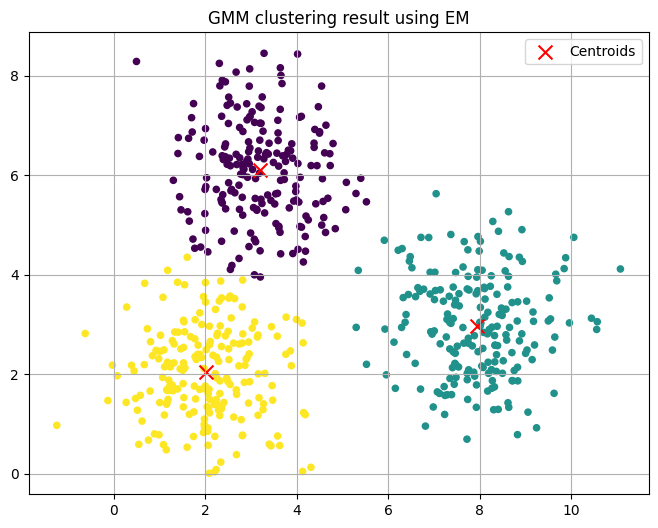

In [179]:
# === 3. Huấn luyện và trực quan hóa ===
if __name__ == "__main__":
    X = generate_data()
    model = GMM(n_components=3, verbose = True)
    model.fit(X)
    labels = model.predict(X)

    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap="viridis", s=20)
    plt.scatter(model.means[:, 0], model.means[:, 1], c="red", marker="x", s=100, label="Centroids")
    plt.title("GMM clustering result using EM")
    plt.legend()
    plt.grid(True)
    plt.show()

### Assignment 2 (2 scores):

Use the Gaussian Mixture Model to filter out background of a given image.

In [180]:
from PIL import Image
import cv2

In [181]:
def remove_background(image_path, n_components=3, bg_strategy="largest_cluster", show_result=True):
    # Load and prepare image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    h, w, c = image_np.shape
    pixels = image_np.reshape(-1, 3).astype(np.float64)

    # Fit GMM
    gmm = GMM(n_components=n_components)
    gmm.fit(pixels)
    labels = gmm.predict(pixels)

    if bg_strategy == "largest_cluster":
        bg_label = np.bincount(labels).argmax()

    elif bg_strategy == "greenish":
        cluster_means = gmm.means
        green_scores = cluster_means[:, 1] - 0.5 * (cluster_means[:, 0] + cluster_means[:, 2])
        bg_label = np.argmax(green_scores)
    else:
        raise ValueError("Unknown bg_strategy. Use 'largest_cluster', 'greenish'.")


    # Create foreground mask
    mask = labels != bg_label
    mask_2d = mask.reshape(h, w)

    # Apply the mask
    result = pixels.copy()
    result[~mask] = [0, 0, 0]
    result_image = result.reshape(h, w, 3).astype(np.uint8)

    # Show result
    if show_result:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(image_np)
        axs[0].set_title("Original Image")
        axs[0].axis("off")

        axs[1].imshow(result_image)
        axs[1].set_title("Background Removed")
        axs[1].axis("off")

        axs[2].imshow(mask_2d, cmap="gray")
        axs[2].set_title("Foreground Mask")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

    return result_image, mask_2d

In [182]:
def remove_background(image_path, n_components=3, bg_strategy="largest_cluster", show_result=True):
    # Load and prepare image
    image = Image.open(image_path).convert("RGB")
    image_np = np.array(image)
    h, w, c = image_np.shape
    pixels = image_np.reshape(-1, 3).astype(np.float64)

    # Fit GMM
    gmm = GMM(n_components=n_components)
    gmm.fit(pixels)
    labels = gmm.predict(pixels)

    if bg_strategy == "largest_cluster":
        counts = np.bincount(labels)
        sorted_indices = np.argsort(counts)[::-1]  # Cụm lớn nhất đứng đầu
        total_pixels = labels.shape[0]

        bg_labels = []
        accum = 0
        for idx in sorted_indices:
            accum += counts[idx]
            bg_labels.append(idx)
            if accum / total_pixels >= 0.5:  # loại bỏ các cụm chiếm tổng ≥ 50%
                break

        mask = ~np.isin(labels, bg_labels)

    elif bg_strategy == "greenish":
        rgb_means = gmm.means
        green_scores = rgb_means[:, 1] - 0.5 * (rgb_means[:, 0] + rgb_means[:, 2])
        threshold = 30 
        bg_labels = np.where(green_scores > threshold)[0]

        if len(bg_labels) == 0:
            print("Không tìm thấy cụm xanh lá. Không áp dụng lọc nền.")
            bg_labels = []

        mask = ~np.isin(labels, bg_labels)

    else:
        raise ValueError("Unknown bg_strategy. Use 'largest_cluster', 'greenish'.")

    mask_2d = mask.reshape(h, w)


    # Apply the mask
    result = pixels.copy()
    result[~mask] = [0, 0, 0]
    result_image = result.reshape(h, w, 3).astype(np.uint8)

    # Show result
    if show_result:
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(image_np)
        axs[0].set_title("Original Image")
        axs[0].axis("off")

        axs[1].imshow(result_image)
        axs[1].set_title("Background Removed")
        axs[1].axis("off")

        axs[2].imshow(mask_2d, cmap="gray")
        axs[2].set_title("Foreground Mask")
        axs[2].axis("off")

        plt.tight_layout()
        plt.show()

    return result_image, mask_2d

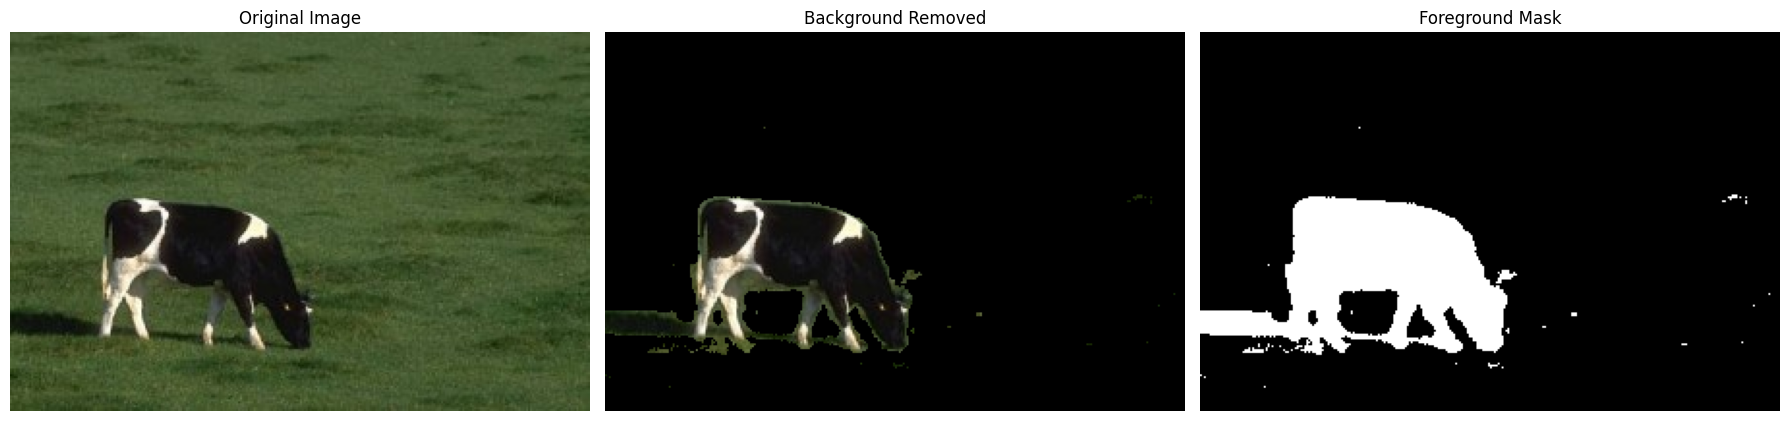

In [183]:
# === Chạy hàm với ảnh cụ thể ===
output_img = remove_background("cow.jpg", n_components=2, bg_strategy="largest_cluster")

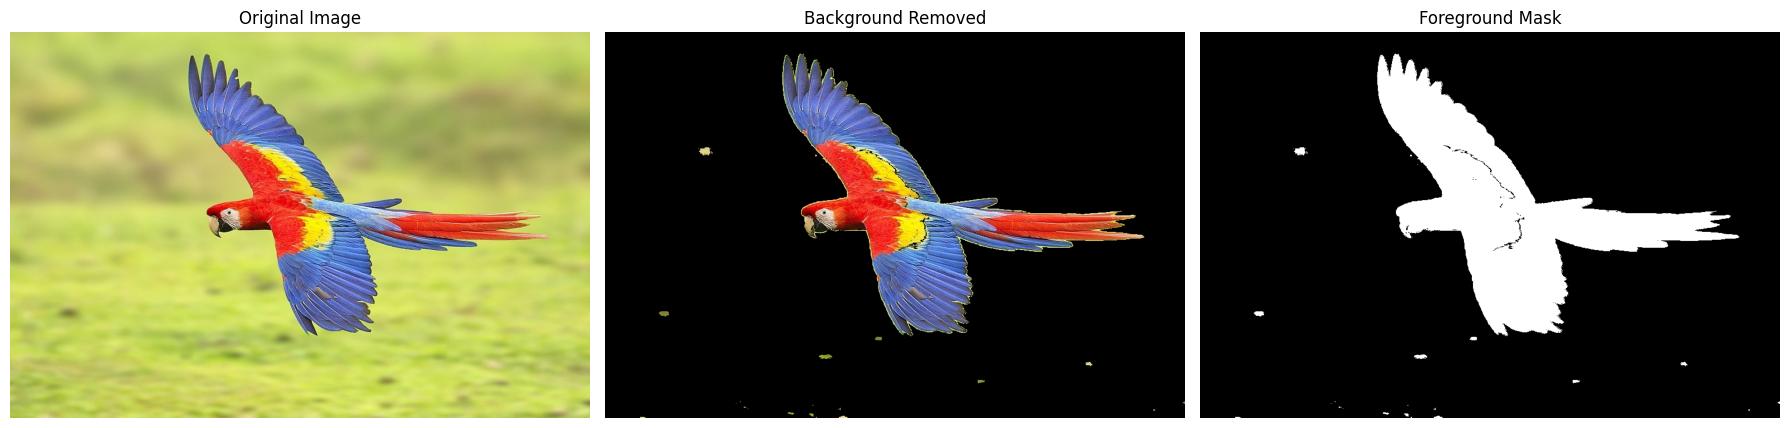

In [184]:
output_img = remove_background("parrot.jpg", n_components=2, bg_strategy="largest_cluster")

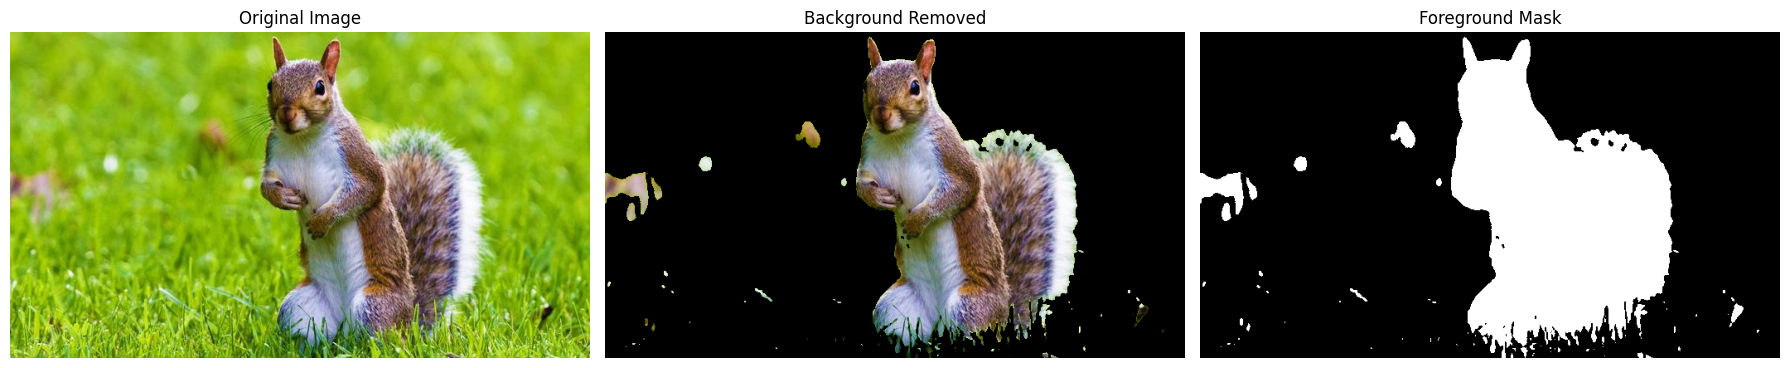

In [185]:
output_img = remove_background("squirrel.jpg", n_components=4, bg_strategy="greenish")